# Exercise 4
## 1. Cart Pole

The objective of these tasks are to implement two different algorithms and compare them to three environments:
* **Cart Pole**
* Lunar Lander
* Mountain Car
<br>

### <b>Group 3</b>


<br>
<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

import moviepy
from moviepy import VideoFileClip

from PIL import Image
import os
from IPython.display import Image as IPImage, display, Video, Image

from __future__ import annotations

import collections
from collections import defaultdict

import statistics

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from typing import Any, List, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

from tqdm import tqdm
from tqdm import trange

from time import time

import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from torchvision import transforms
from torchviz import make_dot, make_dot_from_trace
import torch.nn.functional as F
from torchsummary import summary

from collections import deque

import gc


In [13]:
gc.collect()
torch.mps.empty_cache()  # For M1/MPS

<br>
<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


In [4]:
# Replay Buffer Class for saving the agent's experiences
class ReplayBuffer:
    '''
    Replay Buffer should help the agent to learn NOT right after each experience but rather randomly out of the buffer.
    This prevents the agent from learning from correlated data which can cause stabilizing problems in the RL process.
    Furthermore, deque(maxlen=capacity) acts as a FIFO-vault where old experiences will be overwritten.
    '''
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


In [5]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate=0.0001, gamma=0.99):
        self.q_network = QNetwork(state_dim, action_dim)
        self.target_network = QNetwork(state_dim, action_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.buffer = ReplayBuffer(10000)
        self.loss_fn = nn.SmoothL1Loss()
        self.current_step = 0
        self.action_dim = action_dim

    def select_action(self, state, epsilon):
        self.current_step += 1
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return q_values.argmax().item()

    def train(self, batch_size):
        if len(self.buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        target = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.loss_fn(q_values, target.detach())
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.q_network.parameters(), 5.0)
        self.optimizer.step()



In [6]:
activations = {}

def hook_fn(module, input, output):
    activations[module] = output.detach().cpu().numpy()


In [7]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_units=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.out = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.out(x)


In [8]:
def soft_update(target_net, source_net, tau=0.005):
    for target_param, source_param in zip(target_net.parameters(), source_net.parameters()):
        target_param.data.copy_((1.0 - tau) * target_param.data + tau * source_param.data)


In [21]:
def train_dqn(agent, env, num_episodes=1500, batch_size=128, epsilon_start=1.0, epsilon_end=0.05,
              epsilon_decay=0.001, reward_threshold=195, min_episodes_criterion=100):

    episode_rewards = []
    episodes_reward_window = collections.deque(maxlen=min_episodes_criterion)
    running_reward = 0

    best_reward = 0
    best_model_state = None

    start_time = time()

    with trange(num_episodes, desc="Training", unit="ep") as t:
        for episode in t:
            state, _ = env.reset()
            total_reward = 0
            done = False

            while not done:
                # Update Epsilon value
                epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-agent.current_step * epsilon_decay)
                action = agent.select_action(state, epsilon)
                next_state, reward, done, truncated, _ = env.step(action)
                agent.buffer.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                agent.train(batch_size)
                soft_update(agent.target_network, agent.q_network, tau=0.005)

            episode_rewards.append(total_reward)
            episodes_reward_window.append(total_reward)
            running_reward = np.mean(episodes_reward_window)

            if total_reward > best_reward:
                best_reward = total_reward
                best_model_state = agent.q_network.state_dict()

            t.set_postfix(episode_reward=total_reward, running_avg=running_reward, epsilon=epsilon)

            if running_reward >= reward_threshold and episode >= min_episodes_criterion:
                print(f"\nSolved at episode {episode}: running reward {running_reward:.2f}!")
                break

    end_time = time()
    elapsed = end_time - start_time
    print(f"Training completed in {elapsed:.2f} seconds.")

    if best_model_state is not None:
        torch.save(best_model_state, 'best_dqn_cartpole.pth')

    torch.save(agent.q_network.state_dict(), 'dqn_cartpole.pth')

    return episode_rewards


In [22]:
agent = DQNAgent(state_dim=state_dim,
                 action_dim=action_dim,
                 learning_rate=0.0001,
                 gamma=0.99)

agent.q_network.fc1.register_forward_hook(hook_fn)
agent.q_network.fc2.register_forward_hook(hook_fn)
agent.q_network.fc3.register_forward_hook(hook_fn)


episode_rewards = train_dqn(agent, env,
                            num_episodes=1500,
                            batch_size=128,
                            epsilon_start=1.0,
                            epsilon_end=0.05,
                            epsilon_decay=0.001,
                            reward_threshold=195)



Training:  40%|██████████               | 600/1500 [00:58<01:27, 10.26ep/s, episode_reward=500, epsilon=0.05, running_avg=197]


Solved at episode 600: running reward 196.61!
Training completed in 58.46 seconds.


<br>
<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>


# Results (Video and GIF)

<br>

In [25]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, video_folder="cartpole-agent", name_prefix="eval",
                  episode_trigger=lambda x: True)
env = RecordEpisodeStatistics(env, buffer_length=1)

agent.q_network.load_state_dict(torch.load('dqn_cartpole.pth'))
agent.q_network.eval()

state, _ = env.reset()
done = False
step_count = 0

while not done:
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        q_values = agent.q_network(state_tensor)
        action = q_values.argmax().item()

    state, reward, done, truncated, _ = env.step(action)
    step_count += 1

env.close()
print(f"Finished episode after {step_count} steps.")
print("Video successfully saved in folder 'cartpole-agent'!")


/Users/annina/miniconda3/envs/rdl_t4/lib/python3.9/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/annina/Documents/FH/FHStPoelten/RDL/assign4/cartpole-agent2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Finished episode after 548 steps.
Video successfully saved in folder 'cartpole-agent2'!


In [26]:
Video("cartpole-agent/eval-episode-0.mp4", embed=True)


In [27]:
clip = VideoFileClip("cartpole-agent/eval-episode-0.mp4")
clip.write_gif("cartpole_agent_run.gif", fps=30)

{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [600, 400], 'bitrate': 20, 'fps': 50.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.19.100 libx264'}}], 'input_number': 0}], 'duration': 10.96, 'bitrate': 26, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [600, 400], 'video_bitrate': 20, 'video_fps': 50.0, 'video_duration': 10.96, 'video_n_frames': 548}
/Users/annina/miniconda3/envs/rdl_t4/lib/python3.9/site-packages/imageio_ffmpeg/binaries/ffmpeg-macos-aarch64-v7.1 -i cartpole-agent/eval-episode-0.mp4 -loglevel error -f image2pi

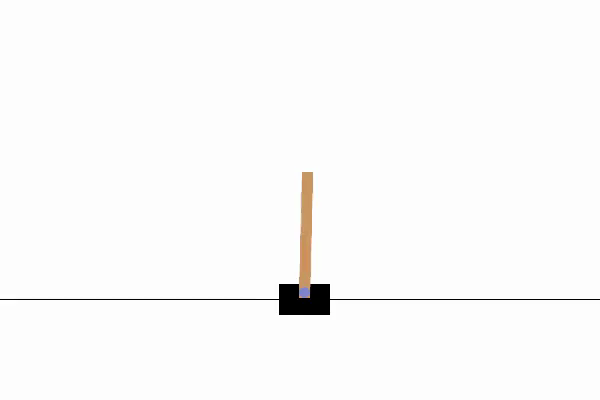

In [28]:
Image(filename="cartpole_agent_run.gif")

<br>
<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

# Plots and Visualizations


In [29]:
smoothed_rewards = pd.Series(episode_rewards).rolling(window=10).mean()

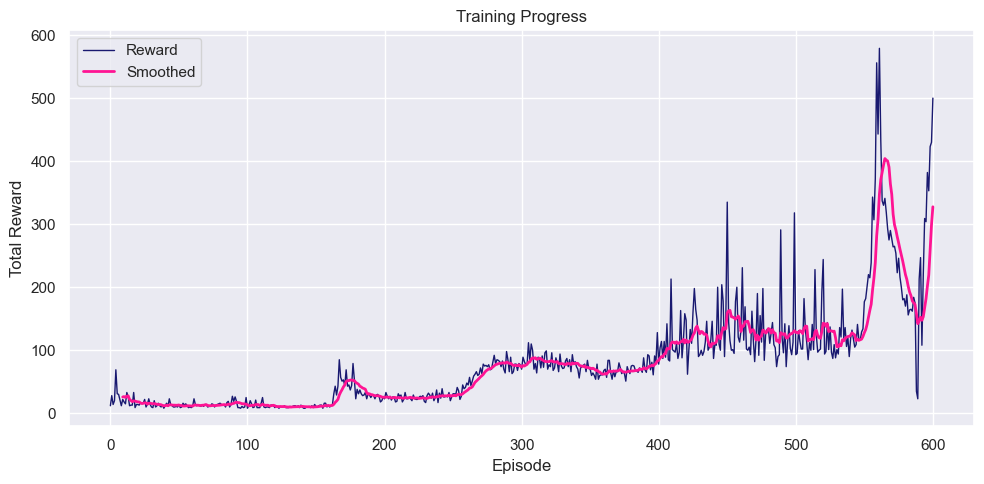

In [30]:
sns.set(style="darkgrid")

plt.figure(figsize=(10,5))
sns.lineplot(x=np.arange(len(episode_rewards)), y=episode_rewards, label='Reward',
             linewidth=1, color='MidnightBlue')
sns.lineplot(x=np.arange(len(smoothed_rewards)), y=smoothed_rewards, label='Smoothed',
             linewidth=2, color='DeepPink')

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.legend()
plt.tight_layout()
plt.show()


<br>

# Interpretation

The training curve shows the total reward achieved by the agent per episode, alongside a smoothed average to highlight overall trends. 
<br>In the initial episodes, the agent performs poorly, with rewards mostly ranging between 10 and 30. This is typical in early training due to high exploration, where the agent takes mostly random actions to gather experience.
<br><br>
As training progresses, the agent gradually improves its performance. From around episode 150 onward, a steady upward trend can be observed, with rewards frequently reaching 50 and beyond. This indicates that the agent is starting to learn more effective balancing strategies. By the mid to late stages of training, particularly from episode 400 onward, the agent consistently achieves higher rewards, with some outliers inbetween.<br>

The smoothed reward curve surpasses the threshold of 195 near episode 600, which is the benchmark for solving the CartPole-v1 environment [according to OpenAI Gym standards](https://gymnasium.farama.org/environments/classic_control/cart_pole/). At this point, the agent achieves a running average reward of 196.61 over the past 100 episodes, confirming that the environment has been successfully solved. 

<br>We can conclude that the training process shows stable learning progression without significant instability, and the agent demonstrates reliable and consistent behavior in balancing the pole by the end of training. There is potential to fine-tune the model further, especially the current results are rather promising.

<br>

<hr>

<br>

In [31]:
agent.q_network.load_state_dict(torch.load('best_dqn_cartpole.pth'))
agent.q_network.eval()


QNetwork(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
)

In [32]:
dummy_input = torch.randn(1, 4)
_ = agent.q_network(dummy_input)


In [33]:
for layer, act in activations.items():
    print(f"Layer: {layer}")
    print(f"Activation shape: {act.shape}")
    print(act)


Layer: Linear(in_features=4, out_features=32, bias=True)
Activation shape: (128, 32)
[[-1.209622    0.10836288 -0.7674952  ... -0.66313004  1.0351211
   0.40078095]
 [-1.1124015   0.15063971 -0.60640055 ... -0.5568083   1.0555924
   0.3754459 ]
 [-1.2432572   0.12449028 -0.7625815  ... -0.6803344   1.032053
   0.4135509 ]
 ...
 [-1.2052643   0.12135503 -0.7459835  ... -0.6416355   1.0187778
   0.4117245 ]
 [-1.223821    0.11702041 -0.7533641  ... -0.6732191   1.0438226
   0.40698558]
 [-1.2164128   0.16537233 -0.6345471  ... -0.65948725  1.0957679
   0.38493556]]
Layer: Linear(in_features=32, out_features=64, bias=True)
Activation shape: (128, 64)
[[ 0.41948873 -0.4359358  -0.61772645 ... -1.1405853   0.7007233
   0.84881556]
 [ 0.40991524 -0.347346   -0.61246717 ... -1.021531    0.6962023
   0.8524227 ]
 [ 0.394317   -0.41176006 -0.6234188  ... -1.1306077   0.6760417
   0.85906136]
 ...
 [ 0.39336777 -0.394884   -0.61785346 ... -1.086946    0.6859834
   0.85712284]
 [ 0.40109694 -0.41

<br>

<hr>

<br>

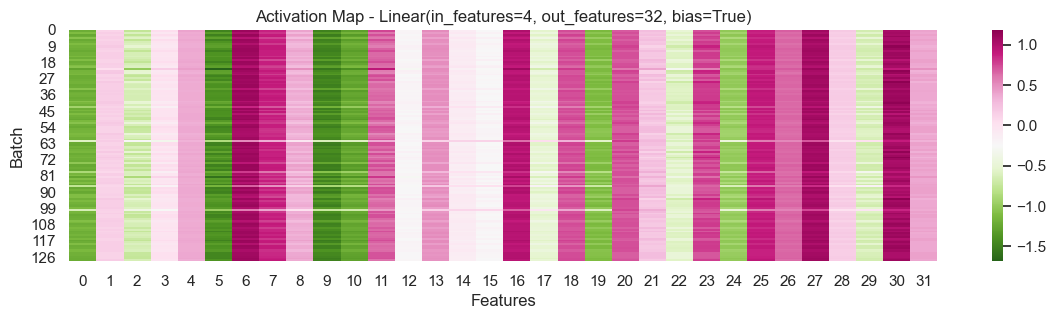

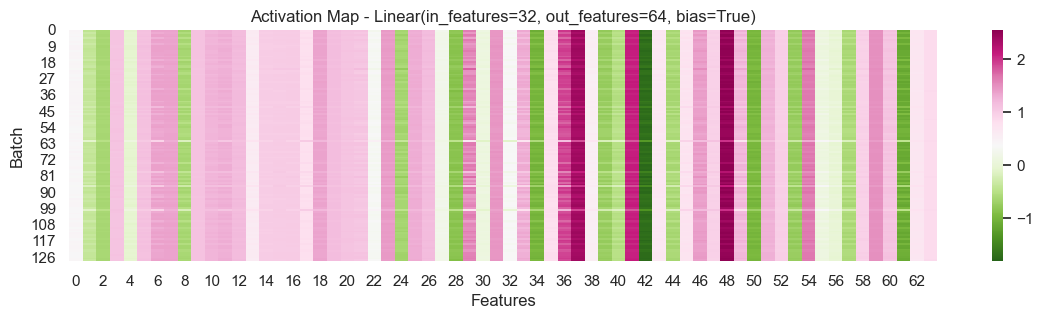

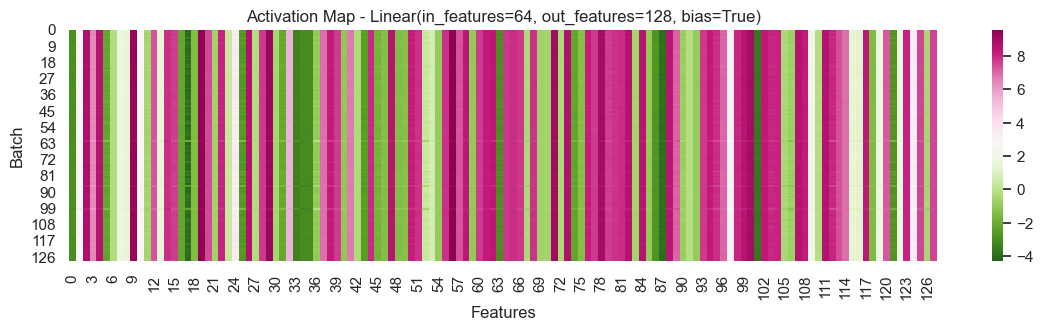

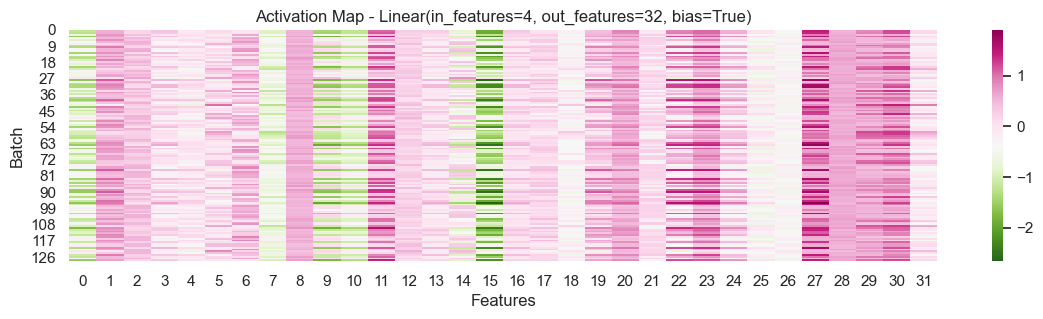

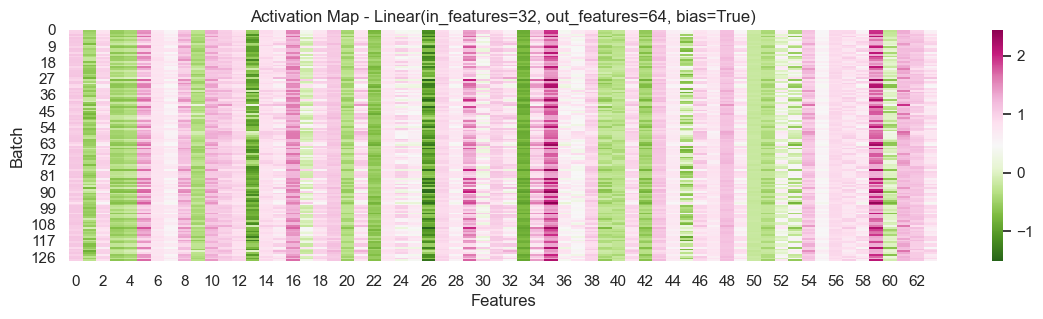

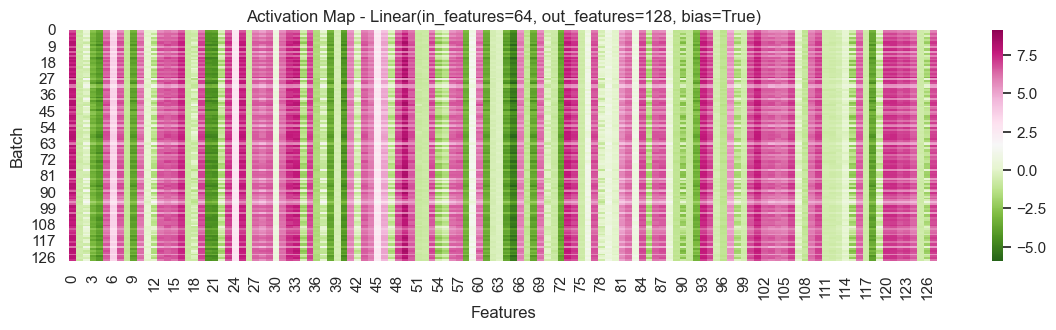

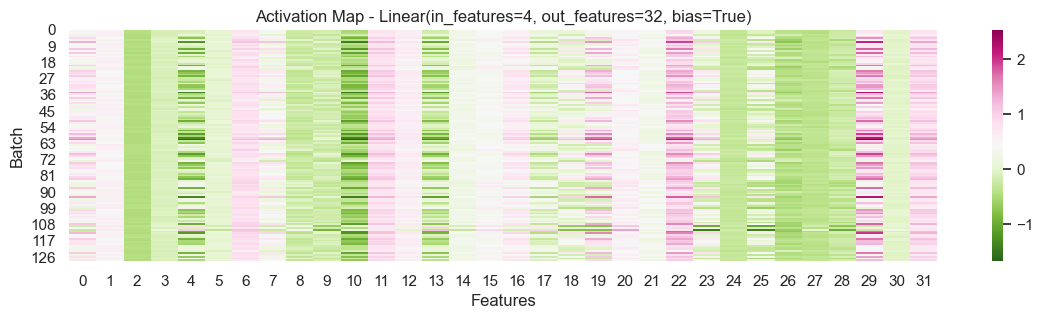

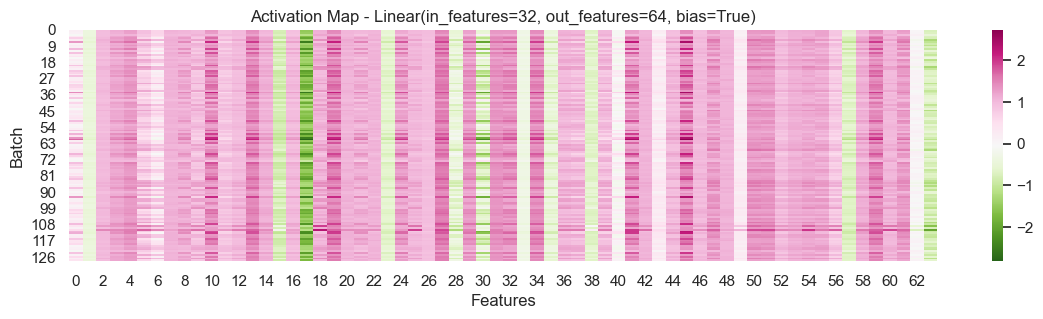

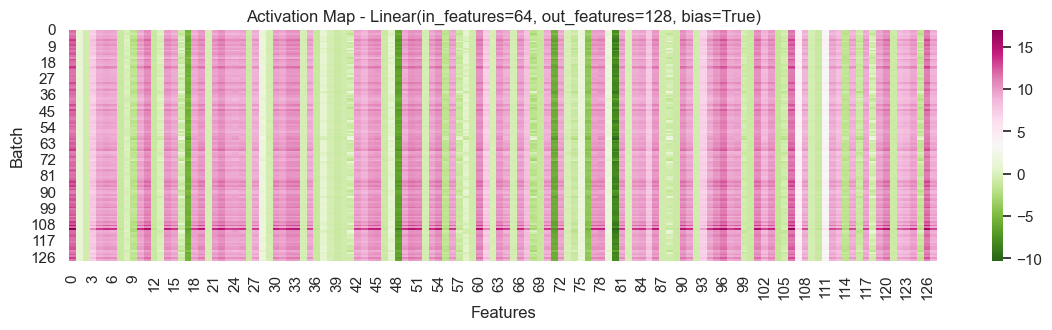

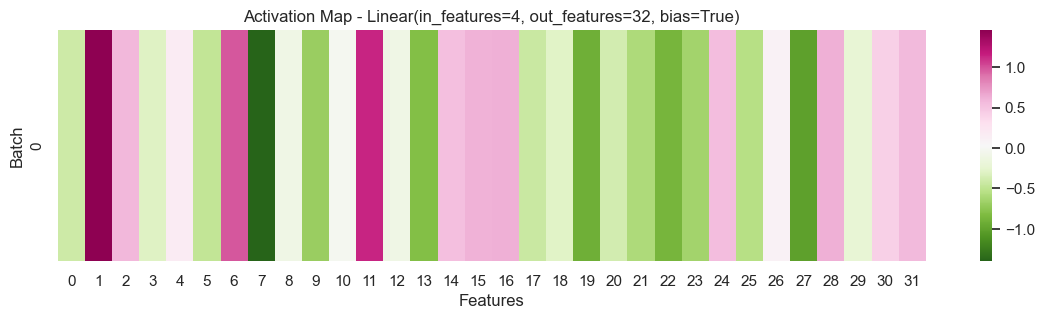

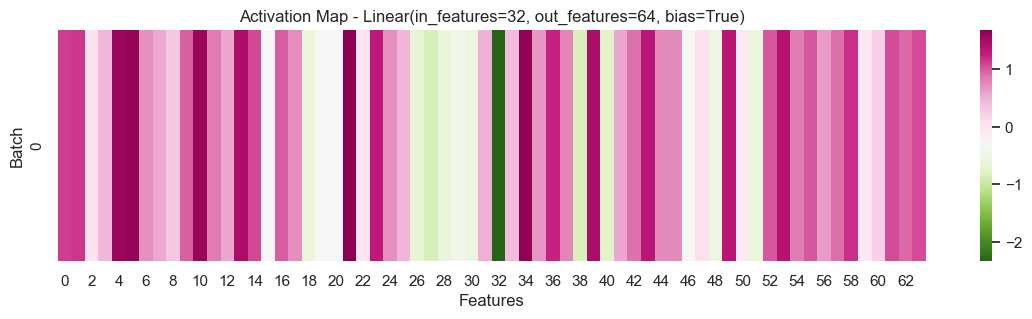

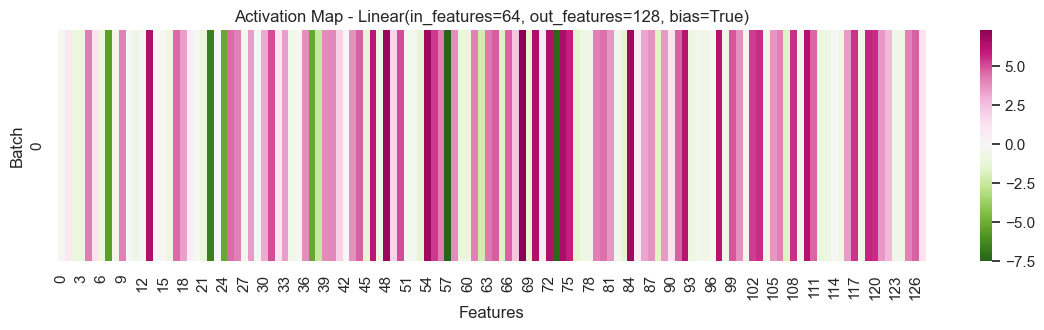

In [34]:
for layer, act in activations.items():
    plt.figure(figsize=(14, 3))
    sns.heatmap(act, cmap="PiYG_r", cbar=True)
    plt.title(f"Activation Map - {layer}")
    plt.xlabel("Features")
    plt.ylabel("Batch")
    plt.show()


<br>

# Interpretation

The activation maps reveal a clear progression in feature transformation across the network’s layers.

- Activations in fc1 are well-distributed with evident variation across features.

- fc2 shows a wider range of activation magnitudes, suggesting more complex feature combinations and selective amplification of relevant patterns. We can conclude that this is due to non-linearity and a move toward more abstract representations.

- By the third layer, activations are notably intense and varied, showing that the network refines inputs into high-level features to inform decision-making. Here, we can observe a more effective deep processing in comparison to fc1 or fc2.

The model utilizes each layer effectively and therefore get gradually better and more discriminative activations. The agent becomes more reliable in its policy learning and action differentiation.
<br>

<hr>

<br>

In [35]:
summary(agent.q_network, input_size=(4,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             160
            Linear-2                   [-1, 64]           2,112
            Linear-3                  [-1, 128]           8,320
            Linear-4                    [-1, 2]             258
Total params: 10,850
Trainable params: 10,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


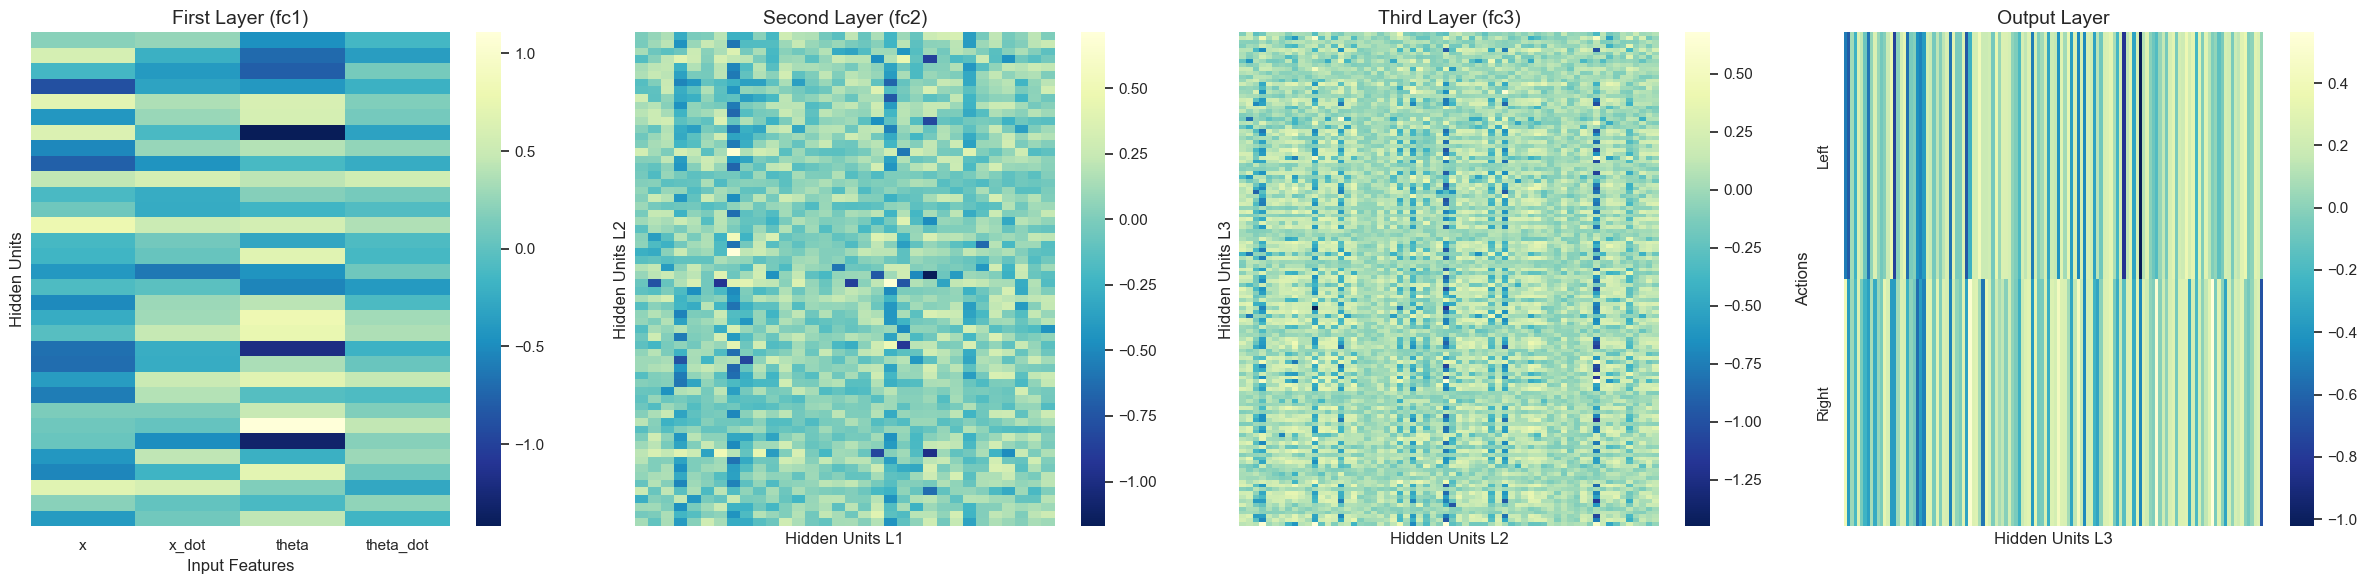

In [40]:
weights_fc1 = agent.q_network.fc1.weight.data.cpu().numpy()
weights_fc2 = agent.q_network.fc2.weight.data.cpu().numpy()
weights_fc3 = agent.q_network.fc3.weight.data.cpu().numpy()
weights_out = agent.q_network.out.weight.data.cpu().numpy()



fig, axes = plt.subplots(1, 4, figsize=(24, 6))
cmap = "YlGnBu_r"

# fc1
sns.heatmap(weights_fc1, cmap=cmap, cbar=True, ax=axes[0],
            xticklabels=["x", "x_dot", "theta", "theta_dot"], yticklabels=False)
axes[0].set_title("First Layer (fc1)", fontsize=14)
axes[0].set_xlabel("Input Features")
axes[0].set_ylabel("Hidden Units")

# fc2
sns.heatmap(weights_fc2, cmap=cmap, cbar=True, ax=axes[1],
            xticklabels=False, yticklabels=False)
axes[1].set_title("Second Layer (fc2)", fontsize=14)
axes[1].set_xlabel("Hidden Units L1")
axes[1].set_ylabel("Hidden Units L2")

# fc3
sns.heatmap(weights_fc3, cmap=cmap, cbar=True, ax=axes[2],
            xticklabels=False, yticklabels=False)
axes[2].set_title("Third Layer (fc3)", fontsize=14)
axes[2].set_xlabel("Hidden Units L2")
axes[2].set_ylabel("Hidden Units L3")

# Output Layer
sns.heatmap(weights_out, cmap=cmap, cbar=True, ax=axes[3],
            annot=False, fmt=".2f", xticklabels=False, yticklabels=["Left", "Right"])
axes[3].set_title("Output Layer", fontsize=14)
axes[3].set_xlabel("Hidden Units L3")
axes[3].set_ylabel("Actions")

plt.tight_layout()
plt.show()




<br>

## Interpretation


#### fc1 - First Layer
In the first layer, the weight distribution reveals clear structure, with **theta (the pole angle)** showing consistently stronger weights compared to other input features. At this stage the agent heavily relies on angle information, which aligns with the task’s requirement to maintain balance.

#### fc2 - Second Layer
In fc2 we can see mostly small, low-magnitude weights, suggesting many weak or inactive connections. This could mean that only a subset of hidden units is effectively contributing to feature transformation, or that this layer might be underutilized.

#### f3 - Third Layer
Here, the weight patterns become more **dense and varied**, indicating that **richer feature representations** are being formed. The network seems to be integrating prior layer outputs into more nuanced internal representations.

#### Output layer
The output layer demonstrates a **strong separation of weights** for the two actions, **Left and Right**, confirming that the agent has developed **distinct policies** for action selection. The uniformity of weights across hidden units suggests the network leverages **consistent activation patterns** when making decisions.

<br>

<hr>

<br>

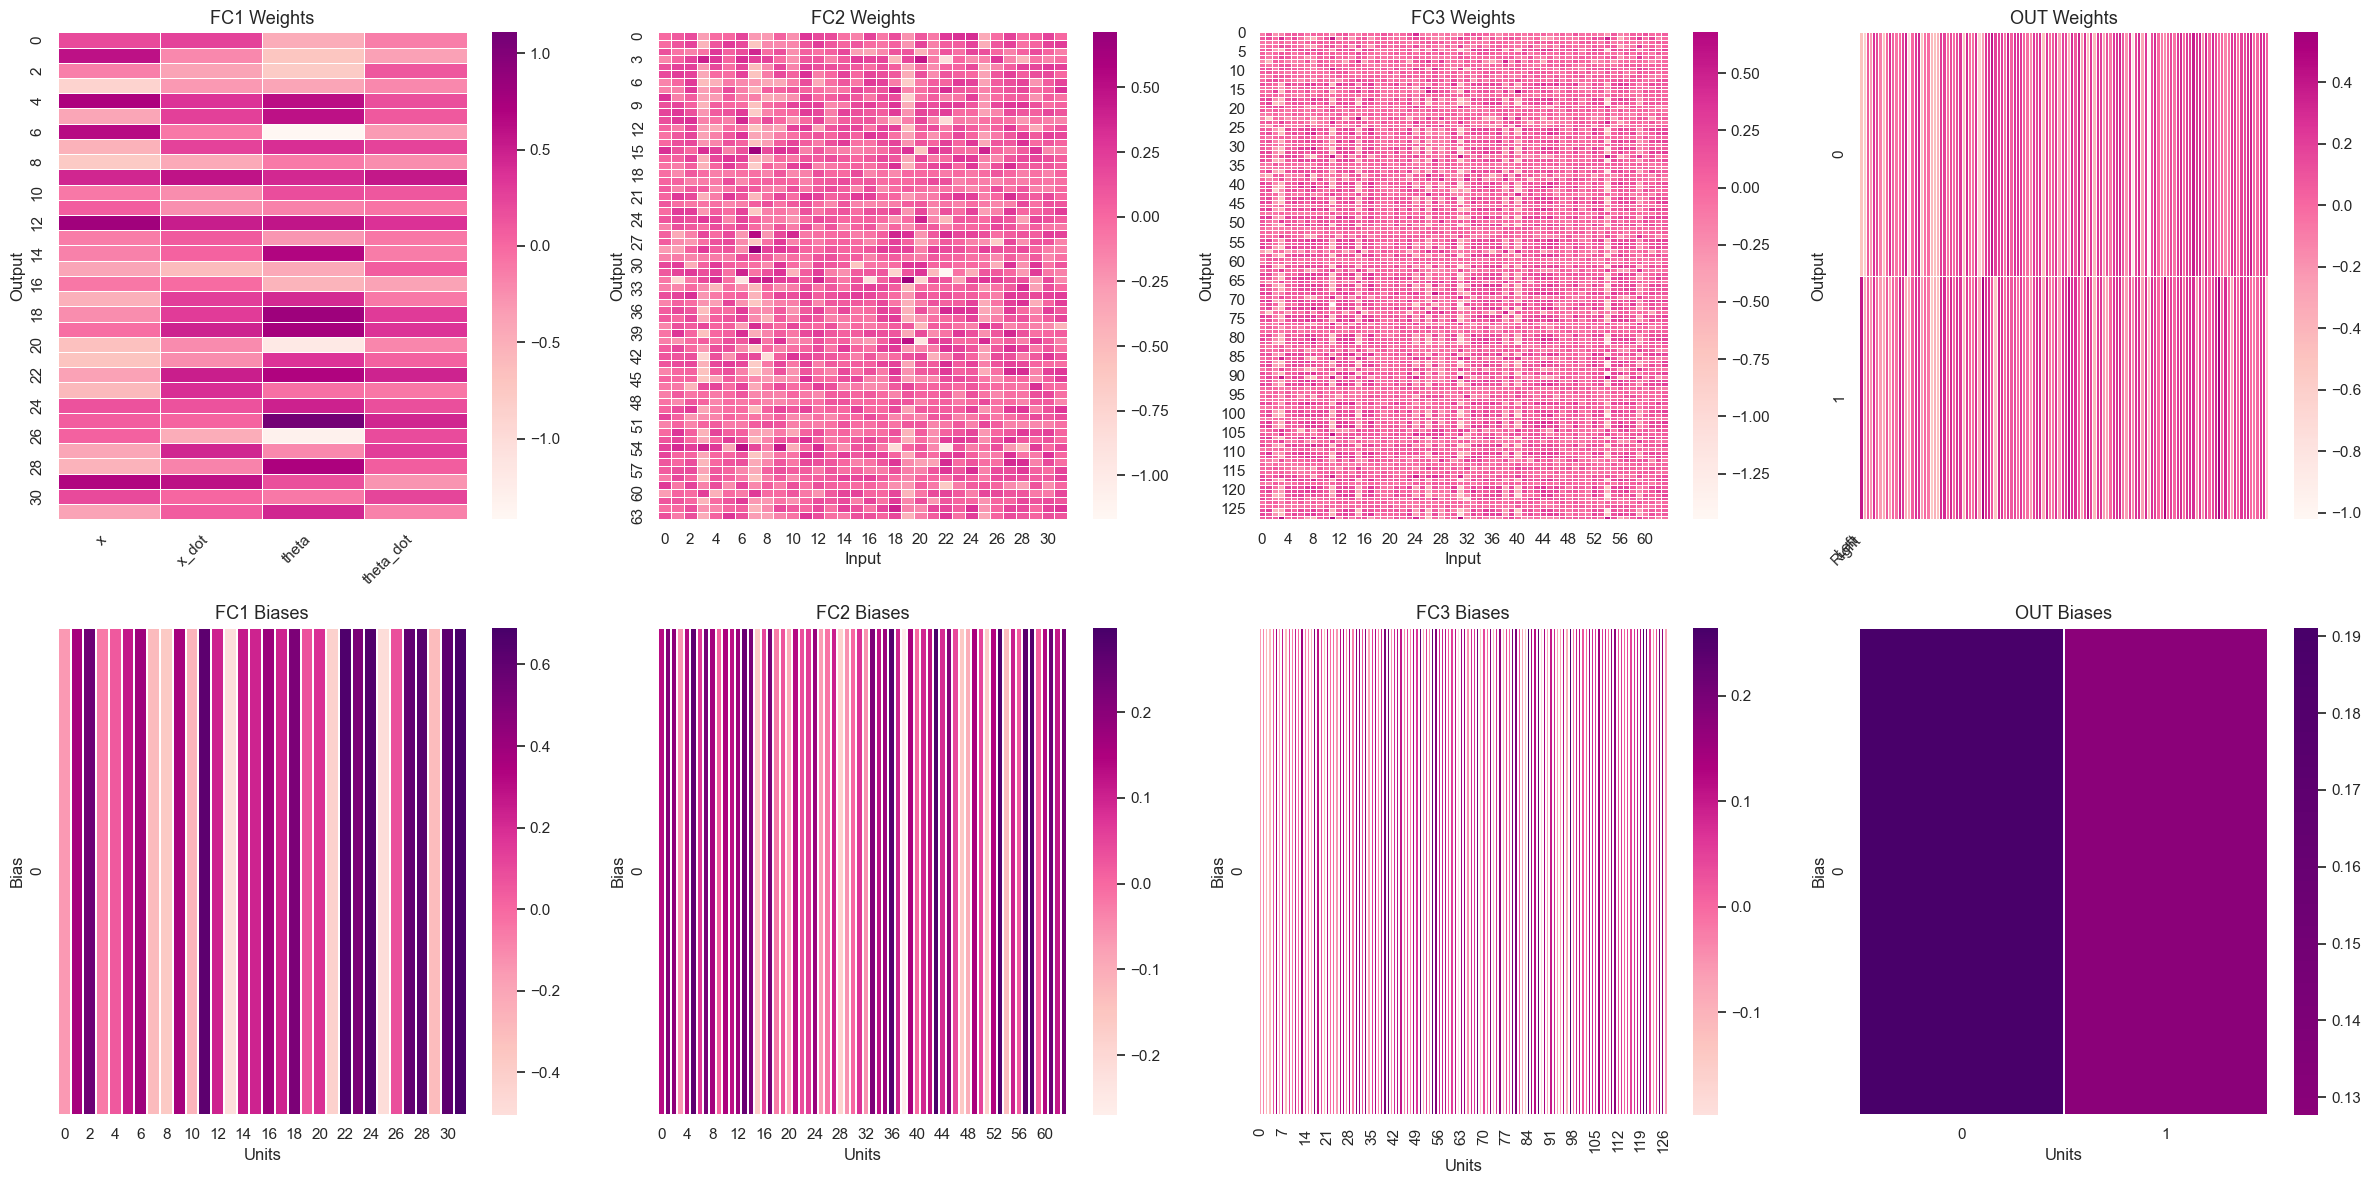

In [41]:
layers = [
    ("fc1", agent.q_network.fc1, ["x", "x_dot", "theta", "theta_dot"]),
    ("fc2", agent.q_network.fc2, None),
    ("fc3", agent.q_network.fc3, None),
    ("out", agent.q_network.out, ["Left", "Right"])
]

fig, axs = plt.subplots(2, 4, figsize=(24, 12))

for i, (name, layer, xlabels) in enumerate(layers):
    weights = layer.weight.data.cpu().numpy()
    sns.heatmap(weights, ax=axs[0, i], cmap="RdPu", cbar=True, center=0, linewidths=0.4, linecolor='white')
    axs[0, i].set_title(f"{name.upper()} Weights", fontsize=13)
    axs[0, i].set_xlabel("Input" if xlabels is None else "")
    axs[0, i].set_ylabel("Output")
    if xlabels:
        axs[0, i].set_xticks(np.arange(len(xlabels))+0.5)
        axs[0, i].set_xticklabels(xlabels, rotation=45, ha='right')

    biases = layer.bias.data.cpu().numpy().reshape(1, -1)
    sns.heatmap(biases, ax=axs[1, i], cmap="RdPu", cbar=True, center=0, linewidths=0.1, linecolor='white')
    axs[1, i].set_title(f"{name.upper()} Biases", fontsize=13)
    axs[1, i].set_xlabel("Units")
    axs[1, i].set_ylabel("Bias")

plt.tight_layout()
plt.show()


<br>

## Interpretation

The network’s weight and bias configurations reflect effective **feature discrimination** and **action specialization**, supporting the agent’s learned behavior in balancing the pole efficiently.<br>

* **FC1 Weights**: Clear structure is visible, particularly strong weights associated with the pole angle (theta) and angular velocity (theta_dot), reflecting their critical role in balance control. The weights show both positive and negative values, indicating diverse influence on hidden units.

* **FC2 Weights**: A denser, more uniformly distributed pattern emerges, with many small-magnitude weights and sparse high-activation connections. This suggests a combination of redundancy and targeted feature refinement in this layer.

* **FC3 Weights**: The weight matrix becomes more intricate, with increased variability and complexity, pointing to deeper abstraction of input signals before final decision-making.

* **Out Weights**: Clear differentiation between the two output neurons (Left, Right) is evident. Each output unit relies on distinct sets of incoming weights, indicating that the agent has formed action-specific pathways.
<br>

### **Biases**

* **Biases in FC1–FC3**: These are small and broadly distributed, suggesting subtle shifts in activation thresholds across hidden units. They support stability while allowing nuanced transformations through layers.

* **Out Biases**: Both output neurons exhibit moderately positive biases, likely serving to calibrate the final Q-values and aid in action selection stability.

<hr>

<br>

In [38]:
dummy_input = torch.zeros(1, 4)
output = agent.q_network(dummy_input)
make_dot(output, params=dict(agent.q_network.named_parameters())).render("cartpole_model", format="png")


'cartpole_model.png'

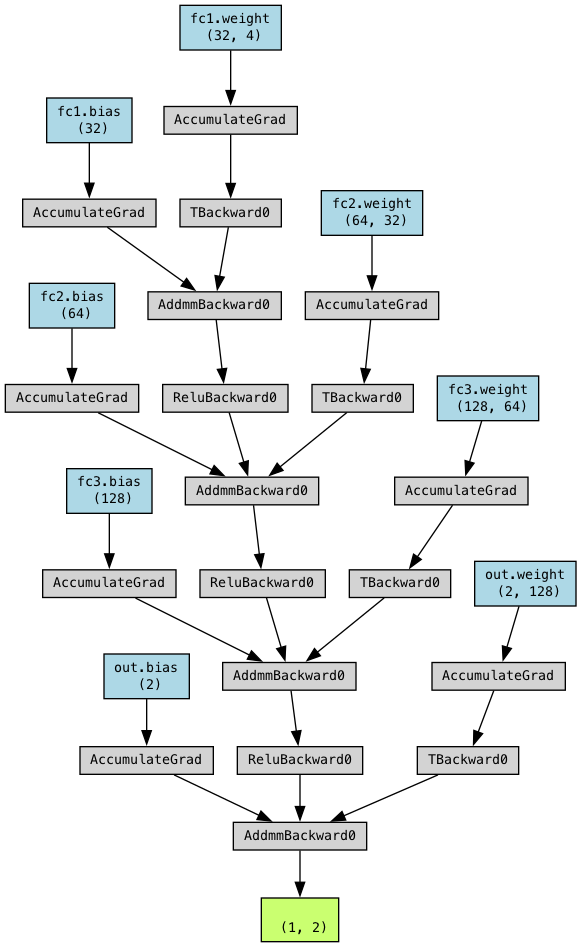

In [39]:
Image("cartpole_model.png")

<br>

# Flow of data and gradients through the Network

Each **blue box** represents learnable parameters: weights and biases for each layer (`fc1`, `fc2`, `fc3`, `out`). 
<br>
**Gray boxes** denote operations during forward and backward passes.
<br>
The **green box** at the bottom shows the final output shape: (1, 2), corresponding to Q-values for the two possible actions (akaLeft, Right).


<br>
<hr style="height:10px;border-width:0;color:#CCD7E9;background-color:#CCD7E9">
<br>

# Sources:

* [Tensorflow Tutorials - Reinforcement Learning](https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic)
* [Gymnasium Introduction - Training an Agent](https://gymnasium.farama.org/introduction/train_agent/)
* [Geeks for Geeks - How to Visualize PyTorch Neural Networks](https://www.geeksforgeeks.org/how-to-visualize-pytorch-neural-networks/)
* [Geeks for Geeks - Visualizing PyTorch Neural Networks](https://www.geeksforgeeks.org/visualizing-pytorch-neural-networks/?ref=ml_lbp)